# 3. 입문용 예제

***내재 변동성***

옵션의 호가로부터 이 옵션의 내재 변동성을 구하고 만기일과 행사가에 따른 그래프를 그려본다. 이 작업은 옵션 트레이더나 리스크 관리자들이 매일 해야 하는 일이다.

***몬테카를로 시뮬레이션***

주가지수가 시간에 따라 변화하는 것을 시뮬레이션하고 일부 결과를 시각화한다. 또한 주가지수에 따른 유러피안 옵션 가치도 계산한다. 몬테카를로 시뮬레이션은 옵션 가격 뿐만 아니라 VAR(value at rist) 값이나 CVA(credit value adjustment) 값을 이용한 위험 관리에서도 가장 기본적인 작업이다.

*** 기술적 분석 ***

추세 신호에 기반한 투자 전략을 백테스트하기 위해 시계열 자로 분석 작업을 구현한다.

## 3-1 내재 변동성 계산

블랙-숄즈-머튼 모형과 같은 옵션 가격 계산 공식을 이용하면 변동성 값을 입력하여 옵션의 가격을 계산할 수 있다. 내재 변동성을 구하는 일은 함수의 입력 변수인 변동성 값을 구하는 작업이기 때문에 결국 수치적 최적화 문제이다.

우선 배당이 없는 기초자산에 대한 유러피안 콜 옵션 가격결정을 위한 블랙-숄즈-머튼모형을 다음 수식으로 설명한다. t = 0을 가정한다

수식 3-1

In [27]:
# 블랙-숄즈-머튼 관련 함수

def bsm_call_value(S0, K, T, r, sigma):
    ''' 블랙-숄즈-머튼 모형을 사용한 유러핑나 콜 옵션 가격결정 공식
    
    params
    ======
    S0: float
        초기 주가 혹은 지수
    K : float
        행사가
    T : float
        만기까지 남은 시간 (연 단위)
    r : float
        고정 무위험 단기 이자율
    sigma: float
        변동성 파라미터
        
    returns
    =======
    value : float
            유러피안 콜 옵션의 현재 가격
    '''
    
    from math import log, sqrt, exp
    from scipy import stats
    
    S0 = float(S0)
    d1 = (log(S0 / K) + (r + 0.5*sigma**2) * T) / (sigma * sqrt(T))
    d2 = (log(S0 / K) + (r - 0.5*sigma**2) * T) / (sigma * sqrt(T))
    value = (S0 * stats.norm.cdf(d1, 0.0, 1.0) - K * exp(-r * T) * stats.norm.cdf(d2, 0.0, 1.0))
    # stats.norm.cdf --> 정규분포의 누적확률 분포 계산
    return value

In [28]:
# 베가 계산 함수

def bsm_vega(S0, K, T, r, sigma):
    '''
    params
    ======
    S0 : float
        초기 주가 혹은 지수
    K : float
        행사가
    T : float
        만기까지 남은 시간(연 단위)
    r : float
        고정 무위험 단기 이자율
    sigma : float
        변동성 파라미터
    
    returns
    =======
    vega : float
        블랙-숄즈-머튼 공식을 변동성에 대해 1차 미분한 값. 베가
    
    '''
    
    from math import log, sqrt, exp
    from scipy import stats
    
    S0 = float(S0)
    d1 = (log(S0 / K) + (r + 0.5*sigma**2) * T) / (sigma * sqrt(T))
    vega = S0 * stats.norm.cdf(d1, 0.0, 1.0) * sqrt(T)
    return vega

In [30]:
# 내재 변동성 계산 함수

def bsm_call_imp_vol(S0, K, T, r, C0, sigma_est, it=100):
    '''
    블랙-숄즈-머튼 모형을 사용한 유러피안 옵션의 내재 변동성 계산
    
    params
    ======
    S0 : float
        초기 주가 혹은 지수
    K : float
        행사가
    T : float
        만기까지 남은 시간(연 단위)
    r : float
        고정 무위험 단기 이자율
    sigma_est : float
        변동성 파라미터 초기 추정치
    it : integer
        반복 계산 횟수
        
    returns
    =======
    sigma_est : float
        수치적으로 추정한 내재 변동성
    '''
    for i in range(it):
        sigma_est -= ((bsm_call_value(S0, K, T, r, sigma_est) - C0) / bsm_vega(S0, K, T, r, sigma_est))
        
    return sigma_est
    

2014년 3월 31일 시점에서 VSTOXX 지수 종가는 $V_0$ = 17.6639이다. 여기서는 주가 지수가 아닌 변동성 지수를 사용하므로 변수명을 S가 아닌 V로 한다.

In [32]:
V0 = 17.6639

무위험 단기 이자율은 연리 1%이다.

In [33]:
r = 0.01

In [35]:
import pandas as pd

In [39]:
h5 = pd.HDFStore('./original/py4fi/jupyter36/source/vstoxx_data_31032014.h5', 'r')

In [41]:
h5

<class 'pandas.io.pytables.HDFStore'>
File path: ./original/py4fi/jupyter36/source/vstoxx_data_31032014.h5

In [47]:
futures_data = h5['futures_data'] # VSTOXX 선물 자료
options_data = h5['options_data'] # VSTOXX 콜 옵션 자료
h5.close()

주어진 포워드 머니니스에 해당하는 행사가를 가진 옵션을 선택하기 위해서는 우선 선물 가격을 알아야 한다.(머니니스는 옵션의 행사가를 현재 주가 혹은 선도가격으로 나눈 갓ㅂ이다. 마니니스가 1이면 등가격 옵션이다.)

In [56]:
import datetime as dt

In [72]:
futures_data['DATE'] = futures_data['DATE'].apply(lambda x: dt.datetime.fromtimestamp(x / 1e9))

In [73]:
futures_data['MATURITY'] = futures_data['MATURITY'].apply(lambda x: dt.datetime.fromtimestamp(x / 1e9))

In [74]:
futures_data

,DATE,EXP_YEAR,EXP_MONTH,PRICE,MATURITY,TTM
496,2014-03-31 09:00:00,2014,4,17.85,2014-04-18 09:00:00,0.049
497,2014-03-31 09:00:00,2014,5,19.55,2014-05-16 09:00:00,0.126
498,2014-03-31 09:00:00,2014,6,19.95,2014-06-20 09:00:00,0.222
499,2014-03-31 09:00:00,2014,7,20.40,2014-07-18 09:00:00,0.299
500,2014-03-31 09:00:00,2014,8,20.70,2014-08-15 09:00:00,0.375
501,2014-03-31 09:00:00,2014,9,20.95,2014-09-19 09:00:00,0.471
502,2014-03-31 09:00:00,2014,10,21.05,2014-10-17 09:00:00,0.548
503,2014-03-31 09:00:00,2014,11,21.25,2014-11-21 09:00:00,0.644


In [50]:
options_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 395 entries, 46170 to 46564
Data columns (total 8 columns):
DATE         395 non-null int64
EXP_YEAR     395 non-null int64
EXP_MONTH    395 non-null int64
TYPE         395 non-null object
STRIKE       395 non-null float64
PRICE        395 non-null float64
MATURITY     395 non-null int64
TTM          395 non-null float64
dtypes: float64(3), int64(4), object(1)
memory usage: 27.8+ KB


In [75]:
options_data.head()

,DATE,EXP_YEAR,EXP_MONTH,TYPE,STRIKE,PRICE,MATURITY,TTM,IMP_VOL
46170,2014-03-31 09:00:00,2014,4,C,1.0,16.85,2014-04-18 09:00:00,0.049,0.0
46171,2014-03-31 09:00:00,2014,4,C,2.0,15.85,2014-04-18 09:00:00,0.049,0.0
46172,2014-03-31 09:00:00,2014,4,C,3.0,14.85,2014-04-18 09:00:00,0.049,0.0
46173,2014-03-31 09:00:00,2014,4,C,4.0,13.85,2014-04-18 09:00:00,0.049,0.0
46174,2014-03-31 09:00:00,2014,4,C,5.0,12.85,2014-04-18 09:00:00,0.049,0.0


In [57]:
options_data['DATE'] = options_data['DATE'].apply(lambda x: dt.datetime.fromtimestamp(x / 1e9))

In [58]:
options_data['MATURITY'] = options_data['MATURITY'].apply(lambda x: dt.datetime.fromtimestamp(x / 1e9))

In [76]:
options_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 395 entries, 46170 to 46564
Data columns (total 9 columns):
DATE         395 non-null datetime64[ns]
EXP_YEAR     395 non-null int64
EXP_MONTH    395 non-null int64
TYPE         395 non-null object
STRIKE       395 non-null float64
PRICE        395 non-null float64
MATURITY     395 non-null datetime64[ns]
TTM          395 non-null float64
IMP_VOL      395 non-null float64
dtypes: datetime64[ns](2), float64(4), int64(2), object(1)
memory usage: 50.9+ KB


In [60]:
options_data[['DATE', 'MATURITY', 'TTM', 'STRIKE', 'PRICE']].head()

,DATE,MATURITY,TTM,STRIKE,PRICE
46170,2014-03-31 09:00:00,2014-04-18 09:00:00,0.049,1.0,16.85
46171,2014-03-31 09:00:00,2014-04-18 09:00:00,0.049,2.0,15.85
46172,2014-03-31 09:00:00,2014-04-18 09:00:00,0.049,3.0,14.85
46173,2014-03-31 09:00:00,2014-04-18 09:00:00,0.049,4.0,13.85
46174,2014-03-31 09:00:00,2014-04-18 09:00:00,0.049,5.0,12.85


In [61]:
options_data['IMP_VOL'] = 0.0
 # 내재 변동성을 저장할 새로운 열

In [77]:
tol = 0.5 # 머니니스 범위

for option in options_data.index:
    # 모든 옵션 시장가에 대해 반복
    forward = futures_data[futures_data['MATURITY'] == \
                          options_data.loc[option]['MATURITY']]['PRICE'].values[0]
    # 옵션과 만기가 일치하는 선물 선택
    if (forward * (1 - tol) < options_data.loc[option]['STRIKE'] < forward * (1 + tol)):
        # 머니니스 범위 내의 옵션만 선택
        imp_vol = bsm_call_imp_vol(
                                    V0,  # VSTOXX value 
                                    options_data.loc[option]['STRIKE'],
                                    options_data.loc[option]['TTM'],
                                    r,   # 단기 이자율, short rate
                                    options_data.loc[option]['PRICE'],
                                    sigma_est=2.,  # 내재 변동성의 초기 추정치, estimate for implied volatility
                                    it=100)
        options_data.ix[option, 'IMP_VOL'] = imp_vol

In [78]:
futures_data['MATURITY']
 # MATURITY라는 이름을 가진 열을 선택

496   2014-04-18 09:00:00
497   2014-05-16 09:00:00
498   2014-06-20 09:00:00
499   2014-07-18 09:00:00
500   2014-08-15 09:00:00
501   2014-09-19 09:00:00
502   2014-10-17 09:00:00
503   2014-11-21 09:00:00
Name: MATURITY, dtype: datetime64[ns]

In [79]:
options_data.loc[46170]
 # 인덱스 값이 46170인 행을 선택

DATE         2014-03-31 09:00:00
EXP_YEAR                    2014
EXP_MONTH                      4
TYPE                           C
STRIKE                         1
PRICE                      16.85
MATURITY     2014-04-18 09:00:00
TTM                        0.049
IMP_VOL                        0
Name: 46170, dtype: object

In [80]:
options_data.loc[46170]['STRIKE']
# STRIKE라는 이름을 가진 열, 46170라는 인덱스를 가진 행의 데이터를 선택

1.0

옵션의 내재 변동성을 시각화해보자. 내재 변동성이 계산도니 것만 이용해 보자

In [93]:
plot_data = options_data[options_data['IMP_VOL'] > 0]
plot_data.head()

,DATE,EXP_YEAR,EXP_MONTH,TYPE,STRIKE,PRICE,MATURITY,TTM,IMP_VOL
46178,2014-03-31 09:00:00,2014,4,C,9.0,8.85,2014-04-18 09:00:00,0.049,2.083386
46179,2014-03-31 09:00:00,2014,4,C,10.0,7.85,2014-04-18 09:00:00,0.049,1.804194
46180,2014-03-31 09:00:00,2014,4,C,11.0,6.85,2014-04-18 09:00:00,0.049,1.550283
46181,2014-03-31 09:00:00,2014,4,C,12.0,5.85,2014-04-18 09:00:00,0.049,1.316103
46182,2014-03-31 09:00:00,2014,4,C,13.0,4.85,2014-04-18 09:00:00,0.049,1.097184


만기별로 그림을 그리는 코드이며, 결과는 그림 [3-1]이다. 주식이나 외환시장과 마찬가지로 변동성 스마일 현상을 볼 수 있다. 또한 변동성 스마일은 만기가 짧을 수록 더 두드러지고 만기가 길어지면 약해진다.

In [88]:
maturities = sorted(set(options_data['MATURITY']))
maturities

[Timestamp('2014-04-18 09:00:00'),
 Timestamp('2014-05-16 09:00:00'),
 Timestamp('2014-06-20 09:00:00'),
 Timestamp('2014-07-18 09:00:00'),
 Timestamp('2014-08-15 09:00:00'),
 Timestamp('2014-09-19 09:00:00'),
 Timestamp('2014-10-17 09:00:00'),
 Timestamp('2014-11-21 09:00:00')]

In [89]:
from matplotlib import pyplot as plt
%matplotlib inline

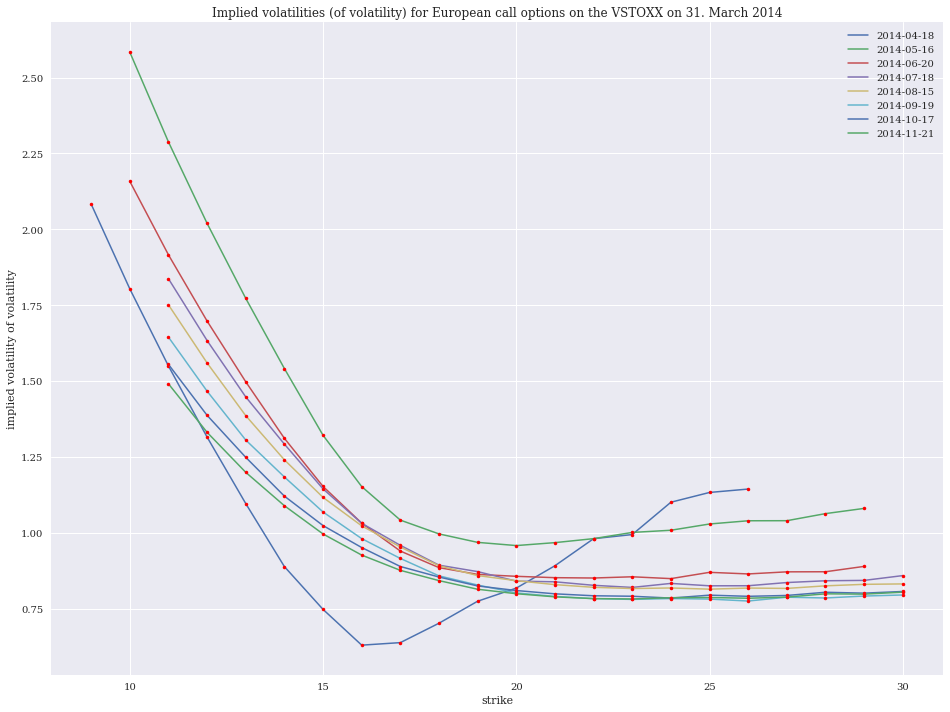

In [111]:
plt.figure(figsize=(16, 12))

for maturity in maturities:
    data = plot_data[options_data.MATURITY == maturity]
    # 만기 maturity 값을 가진 자료만 선택
    plt.plot(data['STRIKE'], data['IMP_VOL'], label=maturity.date(), lw=1.5)
    plt.plot(data['STRIKE'], data['IMP_VOL'], 'r.', label='')
plt.grid(True)
plt.xlabel('strike')
plt.ylabel('implied volatility of volatility')
plt.title('Implied volatilities (of volatility) for European call options on the VSTOXX on 31. March 2014')
plt.legend()
plt.show()

groupby 메서드를 사용하여 새로운 인덱스를 만들어보자. 우선 MATURITY를 기준으로 그룹화하고 이를 다시 STRIKE 기준으로 그룹화한다. 이떄 PRICE 열과 IMP_VOL 열은 유지한다.

In [124]:
keep = ['PRICE', 'IMP_VOL']

group_data = plot_data.groupby(['MATURITY', 'STRIKE'])[keep]
group_data

Groupby 연산 이후 자료를 얻기 위해서는 sum과 같은 취합 연산(aggregation)을 해야 한다. 그룹당 하나의 자료밖에 없기 때문에 sum을 하면 바로 그 자료가 나온다.

In [125]:
group_data = group_data.sum()

In [126]:
group_data.head()

PRICE   IMP_VOL
MATURITY            STRIKE                 
2014-04-18 09:00:00 9.0      8.85  2.083386
                    10.0     7.85  1.804194
                    11.0     6.85  1.550283
                    12.0     5.85  1.316103
                    13.0     4.85  1.097184

이 겨로가로 나온 DataFrame 객체는 2계층 인덱스와 2개의 열을 가진다. 인덱스 값은 다음과 같다.

In [130]:
group_data.index.levels

FrozenList([[2014-04-18 09:00:00, 2014-05-16 09:00:00, 2014-06-20 09:00:00, 2014-07-18 09:00:00, 2014-08-15 09:00:00, 2014-09-19 09:00:00, 2014-10-17 09:00:00, 2014-11-21 09:00:00], [9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0]])

## 3-2 몬테카를로 시뮬레이션

다른 수치해석 방법과 달리 몬테카를로 방법은 계싼량이나 복잡도가 차원에 따라 선형적으로 증가하기 때문에 고차원 문제를 쉽게 풀 수 있다.

몬테카를로 방법의 단점은 아주 쉬운 문제를 푸는 데에도 계산량이 많고 메모리를 많이 요구한다는 점이다. 따라서 이를 효율적으로 구현하는 것이 중요하다.

*** 순수 파이썬 구현 ***

*** NumPy를 사용한 벡터화 ***

*** 완전 벡터화 ***

In [134]:
S0 = 100
K = 105
T = 1
r = 0.05
sigma = 0.2
bsm_call_value(S0, K, T, r, sigma)

8.021352235143176

### 3-2-1 순수 파이썬 구현

이 코드는 하나의 경로를 50개의 구간으로 나누며 250,000개의 샘플 경로를 생성한다.

In [141]:
from time import time
from math import exp, sqrt, log
from random import gauss, seed

seed(20000)
t0 = time()

# parameters, 인수
S0 = 100. # 초깃값
K = 105. # 행사가
T = 1.0 # 만기
r = 0.05 # 무위험 단기 이자율
sigmia = 0.2 # 변동성
M = 50 # 시간 구간 개수
dt = T / M # 하나의 시간 구간의 길이
I = 250000 # 샘플 경로의 수

# 경로 하나당 M개의 시간 구간을 가지는 I개의 샘플 경로를 생성
S = []
for i in range(I):
    path = []
    for t in range(M + 1):
        if t == 0:
            path.append(S0)
        else:
            z = gauss(0.0, 1.0)
            St = path[t - 1] * exp((r - 0.5 * sigma ** 2) * dt
                                  + sigma * sqrt(dt) * z)
            path.append(St)
    S.append(path)

In [144]:
import numpy as np

In [145]:
np.shape

(250000, 51)